# Лабораторная работа 2.

## Выполнил

Ткачев Алексей Игоревич

Группа 381806-2

ФИИТ

4 курс

# Подключение нужных библиотек

`matplotlib` - для отображения изображений

`numpy` - для удобной и быстрой работы с многомерными массивами

`cv2` - для открытия изображений и более точной работы с ее пикселями.

In [544]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [545]:
def out(img):
  plt.imshow(img)

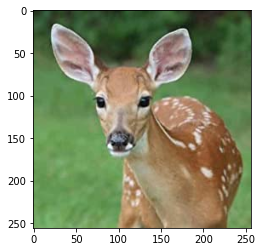

In [546]:
img = cv2.imread("animal.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out(img)

# Сверточные фильтры

Возьмем количество будущих каналов = 5 (`conv_channels_count = 5`), возьмем синаптическое ядро размером `kernel_width` на `kernel_height` (3x3) - такой можно взять, так как изображение небольшое. Возьмем три числа: длину, высоту и ширину изображения. Затем создадим `offset` смещение для каждого канала и создадим `W` - свертку, 4-х мерный массив - натренированные фильтры, детектирующие определенные свойства объектов на изображениях. Зададим также случайный сдвиг `offset` для каждого полученного канала. 

Возьмем нормальное распределение случайных величин, так как оно наиболее распространенное в жизни.

In [547]:
conv_channels_count = 5
kernel_width = 3
kernel_height = kernel_width
image_width = img.shape[0]
image_height = img.shape[1]
image_channels = img.shape[2]
offset = np.random.normal(loc=1, scale=1, size=(conv_channels_count))
W = np.random.normal(loc=1, scale=1, size=(conv_channels_count, kernel_width, kernel_height, image_channels))
offset

array([0.35646408, 2.11383855, 0.48944049, 1.25354232, 0.64648945])

In [548]:
W

array([[[[ 4.85228068e+00,  8.86625794e-02,  1.43802563e+00],
         [ 6.08175366e-01, -1.58908965e-01,  1.89009696e+00],
         [-2.24209600e-01,  5.72064606e-01,  7.88732978e-01]],

        [[ 1.17274733e+00,  9.13198255e-01,  1.22631157e+00],
         [ 9.40169913e-01,  3.18381297e-01,  1.44837607e-01],
         [ 4.95236611e-01, -6.31968901e-01,  2.02379613e+00]],

        [[ 1.51918533e+00,  6.40775197e-01,  1.25190377e+00],
         [ 1.58167634e+00,  2.14296239e+00,  1.32517769e+00],
         [ 1.68914948e+00,  1.93483850e+00, -5.62125954e-01]]],


       [[[-3.60715838e-01, -2.17329526e-01, -9.18938574e-02],
         [ 3.42249856e-01,  6.98681583e-01,  1.52840523e+00],
         [ 1.62817274e+00,  1.27293989e+00, -2.38025945e-01]],

        [[ 2.80857038e+00,  6.99759152e-01,  1.77875689e+00],
         [ 7.19846520e-01, -2.12646313e-01, -1.24751121e+00],
         [ 9.85783675e-01,  1.08704043e+00,  5.37964910e-01]],

        [[-4.63033886e-01,  1.62663946e+00,  3.07389217e-0

In [549]:
W.mean()

0.8595307739996421

Далее беря каждое из ядер на границах, те пиксели, которые не вошли в ядро (то есть коориднаты пикселей <0, либо > ширины или длины изобарежния, мы их заполним нулями и своего рода "выкенем из рассчетов". 

Будем считать свертку по формуле:     

$$ ConvRes_{c x y} = \sum_{c=0}^{M-1} \sum_{x=0}^{W-1} \sum_{y=0}^{H-1} offset_{c} + \sum_{r=0}^{R-1} \sum_{s=0}^{S-1} \sum_{k=0}^{K-1} img_{x+r, y+s, k} \cdot W_{c r s}$$

`x, y` - текущие координаты пикселя

`c` - светочный канал

`r, s` - ограничения размеров синаптического ядра

`k` - канал изображения (RGB)

`ConvRes` - наши итоговые 5 сверточных слоев

`offset` - заданное нами случайное смещение

Возьмем функцию `img_clamp`, которая будет не давать выходить за границы картинки. Она вернет `img[x][y][c]`, если оно в пределах интервала размеров изображения, а иначе 0.

Заполним изначально сверточные каналы нулями.

In [550]:
def img_clamp(x, y, x_min, x_max, y_min, y_max, current_image_channel, img):
  if x < x_min or x > x_max or y > y_max or y < y_min:
    return 0
  else:
    return img[x][y][current_image_channel]

conv_result = np.zeros(shape=(conv_channels_count, image_width, image_height), dtype=np.float32)
conv_result

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [551]:
conv_result.max(), conv_result.min()

(0.0, 0.0)

In [552]:
from time import time


t = time()

for conv_channel in range(conv_channels_count):

      for x in range(image_width):

          for y in range(image_height):

              conv_result[conv_channel][x][y] = offset[conv_channel]

              for r in range(kernel_width):

                  for s in range(kernel_height):

                      for c in range(image_channels):

                          I = img_clamp(x+r, y+s, 0, image_width-1, 0, image_height-1, c, img)

                          conv_result[conv_channel][x][y] += I * W[m][c][r][s]
time() - t

70.88867688179016

In [553]:
conv_result

array([[[ 756.3216 ,  747.66003,  747.7787 , ...,  701.73193,
          523.3256 ,  287.91608],
        [ 789.5666 ,  783.2984 ,  777.7722 , ...,  762.55164,
          564.1223 ,  315.26044],
        [ 803.32983,  795.25726,  786.5613 , ...,  826.2108 ,
          610.8617 ,  340.65604],
        ...,
        [2624.9814 , 2594.932  , 2571.0947 , ..., 2318.6042 ,
         1887.568  , 1117.2019 ],
        [1395.4473 , 1380.2749 , 1363.9764 , ..., 1229.3007 ,
         1239.7034 ,  763.0975 ],
        [ 677.3924 ,  670.0599 ,  661.959  , ...,  604.3595 ,
          463.0991 ,  203.59474]],

       [[ 758.079  ,  749.4174 ,  749.536  , ...,  703.4893 ,
          525.08295,  289.67343],
        [ 791.324  ,  785.0558 ,  779.52954, ...,  764.309  ,
          565.8797 ,  317.0178 ],
        [ 805.0872 ,  797.01465,  788.31866, ...,  827.9682 ,
          612.619  ,  342.4134 ],
        ...,
        [2626.739  , 2596.6892 , 2572.852  , ..., 2320.3618 ,
         1889.3253 , 1118.9594 ],
        [139

Посмотрим общие характеристики полученных чисел всех сверточных каналов:

In [554]:
conv_result.mean(), conv_result.min(), conv_result.max()

(2107.8708, 104.94192, 4939.017)

# Нормализация

Нормализуем полученные значения по формуле :    

$$ x_{i j} = deform \cdot \frac{(x_{i j} - \mu_j)}{ \sqrt{\sigma^2_{i j} + ɛ}} + offset $$

$$ \mu_j = \frac{1}{N} \sum_{i} x_{i j} $$

$$ \sigma^2_j = \frac{1}{N} \sum_{i} (x_{i j} - \mu_j) ^ 2$$

Учитываем особенности `python`, нам не обязательно прописывать вручную циклы, достаточно работать напрямую со списками. Операция, примененнная к списку, применяется ко всем его элементам.

Возьмем `esp = 1e-9`, чтобы избежать ошибки деления на ноль.


In [555]:
def normalize(x, deform=1, offset=0, eps=1e-9):
  for channel in range(x.shape[0]):
    mean = np.mean(x[channel], axis=0)
    variance_in_square = np.var(x[channel], axis=0)
    x[channel] = deform * (x[channel] - mean) / np.sqrt(variance_in_square + eps)
  return x

np.mean(conv_result[0], axis=0)

array([2041.4441 , 2047.1863 , 2051.085  , 2050.7256 , 2045.362  ,
       2037.821  , 2029.5475 , 2022.9713 , 2015.4033 , 2009.8881 ,
       2005.4164 , 2005.7648 , 2010.4249 , 2018.2594 , 2028.0532 ,
       2035.3641 , 2035.2969 , 2022.4337 , 2007.6567 , 2016.4486 ,
       2078.0225 , 2193.019  , 2282.5132 , 2323.2246 , 2340.0803 ,
       2348.7124 , 2348.9922 , 2352.1257 , 2351.418  , 2353.8003 ,
       2361.4553 , 2368.7295 , 2374.4392 , 2368.6929 , 2358.1921 ,
       2346.864  , 2336.975  , 2327.267  , 2316.078  , 2305.7275 ,
       2296.1953 , 2290.0217 , 2288.0073 , 2285.4722 , 2279.6875 ,
       2278.6829 , 2285.481  , 2295.5845 , 2303.4873 , 2304.1077 ,
       2302.8098 , 2300.5713 , 2300.7822 , 2303.0571 , 2301.3315 ,
       2299.8894 , 2305.917  , 2311.9849 , 2311.0344 , 2304.0518 ,
       2297.5574 , 2295.3708 , 2294.2476 , 2293.1616 , 2294.465  ,
       2310.0256 , 2333.7717 , 2355.1965 , 2360.412  , 2341.7737 ,
       2291.2065 , 2229.2676 , 2189.4685 , 2187.8684 , 2172.10

In [556]:
np.var(conv_result[0], axis=0)

array([185523.52 , 182398.75 , 178673.38 , 175294.47 , 172246.9  ,
       170174.42 , 167693.56 , 165293.94 , 164671.9  , 166209.62 ,
       168969.53 , 172606.11 , 177647.36 , 182328.53 , 186886.97 ,
       194976.73 , 209819.6  , 224016.22 , 237748.22 , 221350.75 ,
       205094.23 , 351650.34 , 508331.38 , 533394.6  , 521207.53 ,
       481356.66 , 423994.38 , 377272.06 , 346266.7  , 327790.84 ,
       319032.06 , 313653.97 , 313576.2  , 307016.1  , 296421.22 ,
       285862.25 , 283632.66 , 291677.3  , 301668.   , 306007.88 ,
       310882.53 , 319168.53 , 334667.4  , 340598.1  , 335641.88 ,
       328119.03 , 325415.94 , 327336.12 , 329317.3  , 320325.16 ,
       309368.3  , 302217.97 , 303915.7  , 309971.56 , 309687.6  ,
       310803.44 , 322025.22 , 342826.38 , 359645.1  , 372845.56 ,
       386397.72 , 397191.88 , 406642.5  , 421691.75 , 449924.44 ,
       485185.28 , 552046.9  , 631745.06 , 685372.8  , 674445.6  ,
       641111.1  , 659578.94 , 691271.44 , 693630.3  , 718132.

In [557]:
norm_conv_result = normalize(conv_result)

In [558]:
norm_conv_result.min(), norm_conv_result.max(), norm_conv_result.mean()

(-3.5809991, 4.042287, 2.6077032e-08)

Видим, что нормализация действительно произошла. Теперь все числа в новых небольших пределах, а среднее значение находится примерно по середине этого интервала.

# ReLU - функция активации

Применим функцию активации, которая пропускает только положительные сигналы "синапсов". Данная функция наиболее быстрая из многих функций активации. 

На вход мы подаем весь массив, в котором автоматически поканально поэлементно примениться `ReLU`.

In [559]:
def ReLU(x):
  return np.maximum(0, x, dtype=np.float32)

In [560]:
relu_norm_conv_result = ReLU(norm_conv_result)
relu_norm_conv_result 

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.3547813 , 1.2825313 , 1.2302166 , ..., 0.95195085,
         0.97944546, 0.9754516 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.3547834 , 1.2825338 , 1.2302175 , ..., 0.9519501 ,
         0.97944576, 0.97545284],
        [0. 

In [561]:
relu_norm_conv_result.mean(), relu_norm_conv_result.min(), relu_norm_conv_result .max(), relu_norm_conv_result .shape

(0.38955665, 0.0, 4.042287, (5, 256, 256))

Подверждаем, что отрицательных значений больше нет. Следовательно, функция отработала.

# Max Pooling

Итак, мы получили на каждом канале выборку определенных признаков очертаний на изображении. Так как признаки уже выявлены, то настолько большой и подробный канал нам больше не нужен. Уменьшим его, сохранив признаки (уплотним), уменьшив в два раза. Для этого применим операцию `max pooling`, которая "сканирует" ядром (2x2) входной канал и берем из ядра максимальное значение. Следовательно, каждые 4 значения предыдущего канала уплотняются в 1.

Воспользуемся срезами `python`, с помощью их попеременно будет брать квадраты (2x2) по `x` и `y`. То есть сначала ядрами (2х2) пройдемся по первым двум строкам, потом по вторым двум, потом про третьим... и так до конца.

In [562]:
def max_pooling(arr, shape=2):
  conv_channel = arr.shape[0]
  pooled_width = arr.shape[1] // shape
  pooled_height = arr.shape[2] // shape
  res = np.empty((conv_channel, pooled_width, pooled_height), dtype=np.float32)
  for channel in range(conv_channel):
      for x in range(pooled_width):
          for y in range(pooled_height):
              res[channel, x, y] = np.max(arr[channel, x * shape : (x + 1) * shape, y * shape : (y + 1) * shape])
  return res

pooled_relu_norm_conv_result  = max_pooling(relu_norm_conv_result )

In [563]:
relu_norm_conv_result.mean(), relu_norm_conv_result.min(), relu_norm_conv_result.max(), relu_norm_conv_result.shape

(0.38955665, 0.0, 4.042287, (5, 256, 256))

In [564]:
pooled_relu_norm_conv_result.mean(), pooled_relu_norm_conv_result.min(), pooled_relu_norm_conv_result.max(), pooled_relu_norm_conv_result.shape

(0.4594666, 0.0, 4.042287, (5, 128, 128))

Видим, что после `max pooling` размеры наших каналов уменьшились в два раза. В этом и был смысл.

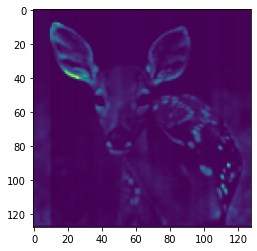

In [565]:
out(pooled_conv_result[0])

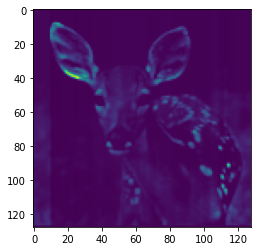

In [566]:
out(pooled_conv_result[1])

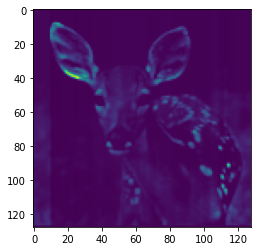

In [567]:
out(pooled_conv_result[2])

# SoftMax - фунция преобразования массива чисел в массив вероятностей

Итак, `softmax` преобразует наши числа в массив вероятностей, то есть их сумма равна единице, и сами они находятся (каждый) на интервале от 0 до 1.

In [568]:
def soft_max(x):
  for channel in range(conv_channels_count):
    x[channel] = np.exp(x[channel]) / sum(np.exp(x[channel]))
  return x

In [569]:
softmax_pooled_relu_norm_conv_result = soft_max(pooled_relu_norm_conv_result)
softmax_pooled_relu_norm_conv_result.shape, softmax_pooled_relu_norm_conv_result.min(), softmax_pooled_relu_norm_conv_result.max()
softmax_pooled_relu_norm_conv_result

array([[[0.00476476, 0.00475684, 0.00475698, ..., 0.00429426,
         0.00438321, 0.0043962 ],
        [0.00476476, 0.00475684, 0.00475698, ..., 0.00429426,
         0.00438321, 0.0043962 ],
        [0.00476476, 0.00475684, 0.00475698, ..., 0.00429426,
         0.00438321, 0.0043962 ],
        ...,
        [0.01514405, 0.01526174, 0.0169633 , ..., 0.0094835 ,
         0.00932008, 0.00897576],
        [0.01846779, 0.01627778, 0.01830052, ..., 0.00925168,
         0.01135583, 0.01170699],
        [0.00476476, 0.00475684, 0.00475698, ..., 0.00429426,
         0.00438321, 0.0043962 ]],

       [[0.00476475, 0.00475684, 0.00475697, ..., 0.00429426,
         0.00438321, 0.0043962 ],
        [0.00476475, 0.00475684, 0.00475697, ..., 0.00429426,
         0.00438321, 0.0043962 ],
        [0.00476475, 0.00475684, 0.00475697, ..., 0.00429426,
         0.00438321, 0.0043962 ],
        ...,
        [0.01514405, 0.01526176, 0.0169633 , ..., 0.0094835 ,
         0.00932008, 0.00897576],
        [0.0

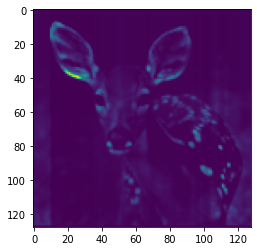

In [570]:
out(softmax_pooled_relu_norm_conv_result[0])

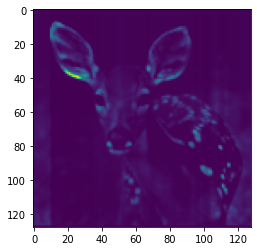

In [571]:
out(softmax_pooled_relu_norm_conv_result[1])

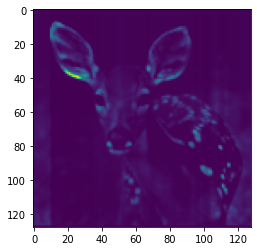

In [572]:
out(softmax_pooled_relu_norm_conv_result[2])

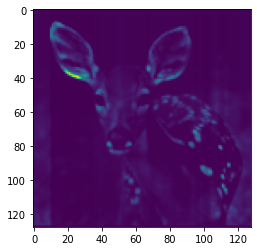

In [573]:
out(softmax_pooled_relu_norm_conv_result[3])

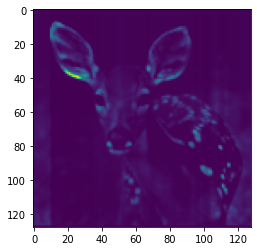

In [574]:
out(softmax_pooled_relu_norm_conv_result[4])